# 1. Importing Libraries, Helper Functions and the Data Paths

### 1.1 Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

In [2]:
from torchvision.datasets import ImageFolder

In [3]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
from typing import List, Tuple, Dict

### 1.2 Importing Helper Functions

In [6]:
from going_modular.engine import train_step
from going_modular.data_setup import create_dataloaders

In [7]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device = torch.device)->Tuple[float,float]:

    #putting model on evaluation mode
    model.eval()

    #Setup test loss and test accuracy values
    val_loss, val_acc = 0,0

    #turning on inference mode (we don't need the gradient engine activated)
    with torch.inference_mode():
        #Loop through Dataloader batches
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            #1. Forward pass
            val_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(val_pred_logits,y)
            val_loss += loss.item()

            #Calculate the accuracy
            val_pred_labels = torch.argmax(val_pred_logits, axis = 1)
            val_acc += (val_pred_labels==y).sum().item()/len(val_pred_labels)

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)

    return val_loss, val_acc

In [8]:
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
         train_dataloader,
         val_dataloader,
         optimizer,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
         epochs: int = 5,
         device = torch.device,
         scheduler = None)->Dict[str,List]:

    #Create dictionary of lists
    results = {"train_loss": [],
              "train_acc": [],
              "val_loss": [],
              "val_acc": []}

    #looping through training and test steps
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn,
                                          optimizer = optimizer,
                                          device = device)

        val_loss, val_acc = val_step(model = model,
                                       dataloader = val_dataloader,
                                       loss_fn = loss_fn,
                                       device = device)

        #print out what's happening
        current_lr = optimizer.param_groups[0]['lr']
        print(f'''Epoch: {epoch+1}| Train loss: {train_loss:.4f} and Train acuuracry: {train_acc:.4f} |
                  Validation loss: {val_loss:.4f} and Validation accuracy: {val_acc:.4f}|
                  Current lr: {current_lr:.6f}''')

        #stepping the scheduler
        if scheduler is not None:
            scheduler.step()

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results

### 1.3 Importing data paths

In [9]:
#original data directories
root_dir = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split')

train_dir = root_dir/'Train'
val_dir = root_dir/'Validation'
test_dir = root_dir/'Test'

train_dir, val_dir, test_dir

(WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Train'),
 WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Validation'),
 WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Test'))

In [10]:
#augmented data directory
train_dir_aug = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Roboflow Split')/'Train'

train_dir_aug

WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Roboflow Split/Train')

In [11]:
os.makedirs('Publication_Exp_Logs', exist_ok = True)

# 2. RegNet Workflow

### Getting the transformations

In [12]:
reg_weights = torchvision.models.RegNet_Y_1_6GF_Weights.DEFAULT
reg_transforms = reg_weights.transforms()

reg_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Now since we know what the required transforms are, we can bring the create the dataloaders

In [13]:
#Original Data
reg_train_loader, reg_val_loader, reg_test_loader, class_names = create_dataloaders(train_dir=train_dir,
                                                                      val_dir = val_dir,
                                                                      test_dir = test_dir,
                                                                      batch_size = 32,
                                                                      transform=reg_transforms)

reg_train_loader, reg_val_loader, reg_test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1c40c628340>,
 <torch.utils.data.dataloader.DataLoader at 0x1c40c62a7f0>)

In [14]:
#Augmented Data
reg_train_data_aug = ImageFolder(root = train_dir_aug,
                          transform=reg_transforms)
reg_train_loader_aug = DataLoader(reg_train_data_aug,
                                 batch_size=32,
                                 shuffle=True)
reg_train_loader_aug

In [15]:
print(class_names)
print(len(class_names))

['Burn Through', 'Lack of Penetration', 'Porosity', 'Undercut']
4


In [16]:
num_classes = len(class_names)

Now we need to modify the final layer to suit our problem. So first lets look at the architecture 

In [17]:
from torchinfo import summary
reg_model = torchvision.models.regnet_y_1_6gf(weights = reg_weights)

summary(reg_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 1000]           --                   True
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 888, 7, 7]      --                   True
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 48, 56,

### the regnet_y_1_6_gf function

In [18]:
def create_regnet_1_6_gf():
    weights = torchvision.models.RegNet_Y_1_6GF_Weights.DEFAULT
    model = torchvision.models.regnet_y_1_6gf(weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(in_features=888, out_features=num_classes).to(device)

    for param in model.fc.parameters():
        param.requires_grad = True

    model.name = 'RegNet_1_6_GF'

    print(f'Created new {model.name} model...')
    return model

## Training 🔥🔥🔥

In [19]:
num_epochs = [5,10,15]

train_dataloaders = {'original_dataset':reg_train_loader,
                    'augmented_dataset':reg_train_loader_aug}

In [20]:
%%time

#setting up a random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#empty dict to store results
all_results = {}

experiment_no = 0

#loop through dataloaders
for dataloader_name, dataloader in train_dataloaders.items():
    #Loop through epochs
    for epoch in num_epochs:

        model = create_regnet_1_6_gf()
        model_name = model.name

        # print info:
        experiment_no += 1
        print(f"[INFO] Experiment Number: {experiment_no}")
        print(f"[INFO] Model: {model_name}")
        print(f"[INFO] DataLoader: {dataloader_name}")
        print(f"[INFO] Number of epochs: {epoch}")

        #Setting up a loss_fn, optimizer and lr_scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
        lr_lambda = lambda epoch: 1.0 if epoch<10 else 0.1
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
        #experiment ID
        experiment_id = f"{model_name}_{dataloader_name}_{epoch}_epochs"
        
        #training model
        results = train(model = model,
                       train_dataloader=dataloader,
                       val_dataloader=reg_val_loader,
                        optimizer=optimizer,
                       loss_fn=criterion,
                       epochs = epoch,
                       device=device,
                       scheduler=scheduler)
        all_results[experiment_id] = results

        print("-"*50,'\n')


import pickle
with open('Publication_Exp_Logs/Regnet_y_one_point_six.pkl', 'wb') as f:
    pickle.dump(all_results,f)
print("All experiments completed... And logged...")

C:\Users\Sadat Iqbal\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Created new RegNet_1_6_GF model...
[INFO] Experiment Number: 1
[INFO] Model: RegNet_1_6_GF
[INFO] DataLoader: original_dataset
[INFO] Number of epochs: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.1421 and Train acuuracry: 0.5460 |
                  Validation loss: 0.8995 and Validation accuracy: 0.7049|
                  Current lr: 0.001000
Epoch: 2| Train loss: 0.7731 and Train acuuracry: 0.7721 |
                  Validation loss: 0.7490 and Validation accuracy: 0.7451|
                  Current lr: 0.001000
Epoch: 3| Train loss: 0.6210 and Train acuuracry: 0.8281 |
                  Validation loss: 0.6609 and Validation accuracy: 0.7264|
                  Current lr: 0.001000
Epoch: 4| Train loss: 0.5351 and Train acuuracry: 0.8529 |
                  Validation loss: 0.6421 and Validation accuracy: 0.7639|
                  Current lr: 0.001000
Epoch: 5| Train loss: 0.4894 and Train acuuracry: 0.8732 |
                  Validation loss: 0.5763 and Validation accuracy: 0.7764|
                  Current lr: 0.001000
-------------------------------------------------- 

Created new RegNet_1_6_GF model...
[INFO] Experiment Number: 2
[INFO] Model: RegNe

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.1271 and Train acuuracry: 0.5515 |
                  Validation loss: 0.9545 and Validation accuracy: 0.6667|
                  Current lr: 0.001000
Epoch: 2| Train loss: 0.7647 and Train acuuracry: 0.7941 |
                  Validation loss: 0.7948 and Validation accuracy: 0.7076|
                  Current lr: 0.001000
Epoch: 3| Train loss: 0.6118 and Train acuuracry: 0.8382 |
                  Validation loss: 0.6774 and Validation accuracy: 0.7611|
                  Current lr: 0.001000
Epoch: 4| Train loss: 0.5514 and Train acuuracry: 0.8254 |
                  Validation loss: 0.6266 and Validation accuracy: 0.7549|
                  Current lr: 0.001000
Epoch: 5| Train loss: 0.4925 and Train acuuracry: 0.8621 |
                  Validation loss: 0.5916 and Validation accuracy: 0.7924|
                  Current lr: 0.001000
Epoch: 6| Train loss: 0.4493 and Train acuuracry: 0.8704 |
                  Validation loss: 0.5642 and Validation accuracy: 0.7924|
 

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.1855 and Train acuuracry: 0.4807 |
                  Validation loss: 0.9657 and Validation accuracy: 0.6479|
                  Current lr: 0.001000
Epoch: 2| Train loss: 0.8073 and Train acuuracry: 0.7665 |
                  Validation loss: 0.7915 and Validation accuracy: 0.7326|
                  Current lr: 0.001000
Epoch: 3| Train loss: 0.6765 and Train acuuracry: 0.7886 |
                  Validation loss: 0.6751 and Validation accuracy: 0.7736|
                  Current lr: 0.001000
Epoch: 4| Train loss: 0.5633 and Train acuuracry: 0.8318 |
                  Validation loss: 0.6268 and Validation accuracy: 0.7639|
                  Current lr: 0.001000
Epoch: 5| Train loss: 0.4956 and Train acuuracry: 0.8575 |
                  Validation loss: 0.6084 and Validation accuracy: 0.7764|
                  Current lr: 0.001000
Epoch: 6| Train loss: 0.4269 and Train acuuracry: 0.8925 |
                  Validation loss: 0.5715 and Validation accuracy: 0.7764|
 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.9459 and Train acuuracry: 0.6760 |
                  Validation loss: 0.8384 and Validation accuracy: 0.6819|
                  Current lr: 0.001000
Epoch: 2| Train loss: 0.6161 and Train acuuracry: 0.8125 |
                  Validation loss: 0.6601 and Validation accuracy: 0.7799|
                  Current lr: 0.001000
Epoch: 3| Train loss: 0.5152 and Train acuuracry: 0.8411 |
                  Validation loss: 0.5784 and Validation accuracy: 0.8021|
                  Current lr: 0.001000
Epoch: 4| Train loss: 0.4550 and Train acuuracry: 0.8586 |
                  Validation loss: 0.5641 and Validation accuracy: 0.8083|
                  Current lr: 0.001000
Epoch: 5| Train loss: 0.4189 and Train acuuracry: 0.8605 |
                  Validation loss: 0.5300 and Validation accuracy: 0.8271|
                  Current lr: 0.001000
-------------------------------------------------- 

Created new RegNet_1_6_GF model...
[INFO] Experiment Number: 5
[INFO] Model: RegNe

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.9452 and Train acuuracry: 0.6775 |
                  Validation loss: 0.7474 and Validation accuracy: 0.7896|
                  Current lr: 0.001000
Epoch: 2| Train loss: 0.6131 and Train acuuracry: 0.8114 |
                  Validation loss: 0.6421 and Validation accuracy: 0.8049|
                  Current lr: 0.001000
Epoch: 3| Train loss: 0.5125 and Train acuuracry: 0.8382 |
                  Validation loss: 0.6097 and Validation accuracy: 0.8146|
                  Current lr: 0.001000
Epoch: 4| Train loss: 0.4497 and Train acuuracry: 0.8531 |
                  Validation loss: 0.5480 and Validation accuracy: 0.8271|
                  Current lr: 0.001000
Epoch: 5| Train loss: 0.4103 and Train acuuracry: 0.8717 |
                  Validation loss: 0.5051 and Validation accuracy: 0.8271|
                  Current lr: 0.001000
Epoch: 6| Train loss: 0.3784 and Train acuuracry: 0.8821 |
                  Validation loss: 0.4902 and Validation accuracy: 0.8271|
 

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.9594 and Train acuuracry: 0.6577 |
                  Validation loss: 0.8064 and Validation accuracy: 0.7229|
                  Current lr: 0.001000
Epoch: 2| Train loss: 0.6076 and Train acuuracry: 0.8222 |
                  Validation loss: 0.7131 and Validation accuracy: 0.7514|
                  Current lr: 0.001000
Epoch: 3| Train loss: 0.5138 and Train acuuracry: 0.8393 |
                  Validation loss: 0.6009 and Validation accuracy: 0.8111|
                  Current lr: 0.001000
Epoch: 4| Train loss: 0.4602 and Train acuuracry: 0.8471 |
                  Validation loss: 0.5466 and Validation accuracy: 0.8208|
                  Current lr: 0.001000
Epoch: 5| Train loss: 0.4110 and Train acuuracry: 0.8776 |
                  Validation loss: 0.5379 and Validation accuracy: 0.8208|
                  Current lr: 0.001000
Epoch: 6| Train loss: 0.3817 and Train acuuracry: 0.8810 |
                  Validation loss: 0.5011 and Validation accuracy: 0.8146|
 

# 3. ConvNeXt Workflow

In [21]:
conv_weights = torchvision.models.ConvNeXt_Small_Weights.DEFAULT
conv_model = torchvision.models.convnext_small(weights=conv_weights)

from torchinfo import summary
summary(conv_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   True
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     4,704                True
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     192                  True
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   True
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     79,296               True
│  

In [22]:
conv_transforms = conv_weights.transforms()
conv_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[230]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [23]:
#original data
conv_train_loader, conv_val_loader, conv_test_loader, class_names = create_dataloaders(train_dir = train_dir,
                          val_dir = val_dir,
                          test_dir = test_dir,
                          batch_size = 32,
                          transform = conv_transforms,
                          )

conv_train_loader, conv_val_loader, conv_test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c4141f0d60>,
 ['Burn Through', 'Lack of Penetration', 'Porosity', 'Undercut'])

In [24]:
#Augmented data
conv_data_aug = ImageFolder(root = train_dir,
                          transform = conv_transforms)
conv_train_loader_aug = DataLoader(conv_data_aug,
                                  batch_size=32,
                                  shuffle=True)
conv_train_loader_aug

In [25]:
num_classes = len(class_names)
print(num_classes)

4


In [26]:
conv_model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)

### Defining the LayerNorm2d class

In [27]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels, eps=1e-6, affine=True):
        super().__init__()
        self.norm = nn.LayerNorm(num_channels, eps=eps, elementwise_affine=affine)

    def forward(self, x):
        # x: (B, C, H, W) → (B, H, W, C)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        # → (B, C, H, W)
        return x.permute(0, 3, 1, 2)

### The ConvNeXt function

In [28]:
def create_convnext_small():
    weights = torchvision.models.ConvNeXt_Small_Weights.DEFAULT
    model = torchvision.models.convnext_small(weights = weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        LayerNorm2d(768,eps = 1e-6, affine=True),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=768, out_features=num_classes)
    ).to(device) 

    for param in model.classifier.parameters():
        param.requires_grad = True

    model.name = 'ConvNeXt_Small'

    print(f'Created new {model.name} model...')
    return model

### Train 🔥🔥🔥

In [29]:
num_epochs = [5,10,15]

train_dataloaders = {'original_dataset':conv_train_loader,
                    'augmented_dataset':conv_train_loader_aug}

In [30]:
%%time

#setting up a random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#empty dict to store results
all_results = {}

experiment_no = 0

#loop through dataloaders
for dataloader_name, dataloader in train_dataloaders.items():
    #Loop through epochs
    for epoch in num_epochs:

        model = create_convnext_small()
        model_name = model.name

        # print info:
        experiment_no += 1
        print(f"[INFO] Experiment Number: {experiment_no}")
        print(f"[INFO] Model: {model_name}")
        print(f"[INFO] DataLoader: {dataloader_name}")
        print(f"[INFO] Number of epochs: {epoch}")

        #Setting up a loss_fn, optimizer and lr_scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
        lr_lambda = lambda epoch: 1.0 if epoch<10 else 0.5
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
        #experiment ID
        experiment_id = f"{model_name}_{dataloader_name}_{epoch}_epochs"
        
        #training model
        results = train(model = model,
                       train_dataloader=dataloader,
                       val_dataloader=conv_val_loader,
                        optimizer=optimizer,
                       loss_fn=criterion,
                       epochs = epoch,
                       device=device,
                       scheduler=scheduler)
        all_results[experiment_id] = results

        print("-"*50,'\n')


import pickle
with open('Publication_Exp_Logs/ConvNeXT_Small.pkl', 'wb') as f:
    pickle.dump(all_results,f)
print("All experiments completed... And logged...")

Created new ConvNeXt_Small model...
[INFO] Experiment Number: 1
[INFO] Model: ConvNeXt_Small
[INFO] DataLoader: original_dataset
[INFO] Number of epochs: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.0479 and Train acuuracry: 0.5901 |
                  Validation loss: 0.7580 and Validation accuracy: 0.7958|
                  Current lr: 0.000300
Epoch: 2| Train loss: 0.6754 and Train acuuracry: 0.8107 |
                  Validation loss: 0.5528 and Validation accuracy: 0.8333|
                  Current lr: 0.000300
Epoch: 3| Train loss: 0.5221 and Train acuuracry: 0.8621 |
                  Validation loss: 0.4559 and Validation accuracy: 0.8521|
                  Current lr: 0.000300
Epoch: 4| Train loss: 0.4186 and Train acuuracry: 0.8934 |
                  Validation loss: 0.4105 and Validation accuracy: 0.8896|
                  Current lr: 0.000300
Epoch: 5| Train loss: 0.3724 and Train acuuracry: 0.9035 |
                  Validation loss: 0.3702 and Validation accuracy: 0.8896|
                  Current lr: 0.000300
-------------------------------------------------- 

Created new ConvNeXt_Small model...
[INFO] Experiment Number: 2
[INFO] Model: Conv

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.1215 and Train acuuracry: 0.5322 |
                  Validation loss: 0.8140 and Validation accuracy: 0.7708|
                  Current lr: 0.000300
Epoch: 2| Train loss: 0.7197 and Train acuuracry: 0.7849 |
                  Validation loss: 0.5869 and Validation accuracy: 0.8208|
                  Current lr: 0.000300
Epoch: 3| Train loss: 0.5295 and Train acuuracry: 0.8575 |
                  Validation loss: 0.4624 and Validation accuracy: 0.8236|
                  Current lr: 0.000300
Epoch: 4| Train loss: 0.4382 and Train acuuracry: 0.8768 |
                  Validation loss: 0.4180 and Validation accuracy: 0.8424|
                  Current lr: 0.000300
Epoch: 5| Train loss: 0.3737 and Train acuuracry: 0.8989 |
                  Validation loss: 0.3677 and Validation accuracy: 0.8771|
                  Current lr: 0.000300
Epoch: 6| Train loss: 0.3409 and Train acuuracry: 0.9035 |
                  Validation loss: 0.3512 and Validation accuracy: 0.8771|
 

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.1942 and Train acuuracry: 0.4899 |
                  Validation loss: 0.9116 and Validation accuracy: 0.6604|
                  Current lr: 0.000300
Epoch: 2| Train loss: 0.7637 and Train acuuracry: 0.7436 |
                  Validation loss: 0.6444 and Validation accuracy: 0.8174|
                  Current lr: 0.000300
Epoch: 3| Train loss: 0.5565 and Train acuuracry: 0.8474 |
                  Validation loss: 0.5003 and Validation accuracy: 0.8521|
                  Current lr: 0.000300
Epoch: 4| Train loss: 0.4635 and Train acuuracry: 0.8695 |
                  Validation loss: 0.4305 and Validation accuracy: 0.8646|
                  Current lr: 0.000300
Epoch: 5| Train loss: 0.3889 and Train acuuracry: 0.9017 |
                  Validation loss: 0.3857 and Validation accuracy: 0.8771|
                  Current lr: 0.000300
Epoch: 6| Train loss: 0.3584 and Train acuuracry: 0.9044 |
                  Validation loss: 0.3463 and Validation accuracy: 0.8708|
 

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Sadat Iqbal\anaconda3\envs\myenv\lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch: 1| Train loss: 1.0768 and Train acuuracry: 0.5882 |
                  Validation loss: 0.7619 and Validation accuracy: 0.7833|
                  Current lr: 0.000300
Epoch: 2| Train loss: 0.6900 and Train acuuracry: 0.8153 |
                  Validation loss: 0.5555 and Validation accuracy: 0.8521|
                  Current lr: 0.000300
Epoch: 3| Train loss: 0.5189 and Train acuuracry: 0.8676 |
                  Validation loss: 0.4252 and Validation accuracy: 0.8931|
                  Current lr: 0.000300
Epoch: 4| Train loss: 0.4179 and Train acuuracry: 0.9090 |
                  Validation loss: 0.3674 and Validation accuracy: 0.9056|
                  Current lr: 0.000300
Epoch: 5| Train loss: 0.3761 and Train acuuracry: 0.9044 |
                  Validation loss: 0.3317 and Validation accuracy: 0.9118|
                  Current lr: 0.000300
-------------------------------------------------- 

Created new ConvNeXt_Small model...
[INFO] Experiment Number: 5
[INFO] Model: Conv

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.2301 and Train acuuracry: 0.4623 |
                  Validation loss: 0.8710 and Validation accuracy: 0.7333|
                  Current lr: 0.000300
Epoch: 2| Train loss: 0.7612 and Train acuuracry: 0.7812 |
                  Validation loss: 0.5974 and Validation accuracy: 0.8236|
                  Current lr: 0.000300
Epoch: 3| Train loss: 0.5482 and Train acuuracry: 0.8686 |
                  Validation loss: 0.4687 and Validation accuracy: 0.8806|
                  Current lr: 0.000300
Epoch: 4| Train loss: 0.4650 and Train acuuracry: 0.8833 |
                  Validation loss: 0.4108 and Validation accuracy: 0.8583|
                  Current lr: 0.000300
Epoch: 5| Train loss: 0.3955 and Train acuuracry: 0.9062 |
                  Validation loss: 0.3581 and Validation accuracy: 0.8771|
                  Current lr: 0.000300
Epoch: 6| Train loss: 0.3452 and Train acuuracry: 0.9219 |
                  Validation loss: 0.3293 and Validation accuracy: 0.8833|
 

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.1446 and Train acuuracry: 0.5267 |
                  Validation loss: 0.8648 and Validation accuracy: 0.6972|
                  Current lr: 0.000300
Epoch: 2| Train loss: 0.7096 and Train acuuracry: 0.8143 |
                  Validation loss: 0.6142 and Validation accuracy: 0.8361|
                  Current lr: 0.000300
Epoch: 3| Train loss: 0.5304 and Train acuuracry: 0.8695 |
                  Validation loss: 0.5177 and Validation accuracy: 0.8771|
                  Current lr: 0.000300
Epoch: 4| Train loss: 0.4374 and Train acuuracry: 0.8888 |
                  Validation loss: 0.4382 and Validation accuracy: 0.8833|
                  Current lr: 0.000300
Epoch: 5| Train loss: 0.3719 and Train acuuracry: 0.9099 |
                  Validation loss: 0.4033 and Validation accuracy: 0.8833|
                  Current lr: 0.000300
Epoch: 6| Train loss: 0.3469 and Train acuuracry: 0.9053 |
                  Validation loss: 0.3873 and Validation accuracy: 0.8958|
 

# 4. Model Evaluation using loss curves

In [2]:
import matplotlib.pyplot as plt
import pickle
import os

def plot_loss_curves_separate_figures(
    pickle_path: str, 
    model_name: str = None, 
    save_plots: bool = False, 
    save_dir: str = "experiment_plots"
):
    """
    Loads a pickle file of training results and plots loss/accuracy curves for each experiment.

    Args:
        pickle_path (str): Path to the .pkl file containing logged experiment results.
        model_name (str, optional): Optional model name for plot titles.
        save_plots (bool): If True, saves plots instead of showing them.
        save_dir (str): Directory to save plots if save_plots is True.
    """
    
    with open(pickle_path, 'rb') as f:
        exp_results = pickle.load(f)

    # Auto-detect model name from first key
    if model_name is None and len(exp_results) > 0:
        model_name = list(exp_results.keys())[0].split("_")[0]

    # Create save directory if needed
    if save_plots:
        os.makedirs(save_dir, exist_ok=True)

    for exp_id, results in exp_results.items():
        train_loss = results["train_loss"]
        val_loss = results["val_loss"]
        train_acc = results["train_acc"]
        val_acc = results["val_acc"]
        epochs = range(len(train_loss))

        # Plot
        plt.figure(figsize=(12, 5))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label="Train Loss")
        plt.plot(epochs, val_loss, label="Val Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Loss Curve\n{exp_id}")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label="Train Accuracy")
        plt.plot(epochs, val_acc, label="Val Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy Curve\n{exp_id}")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.suptitle(f"{model_name} - {exp_id}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        if save_plots:
            plot_filename = os.path.join(save_dir, f"{exp_id}.png")
            plt.savefig(plot_filename)
            plt.close()
        else:
            plt.show()


### 4.1 RegNet_y_1_6_mf

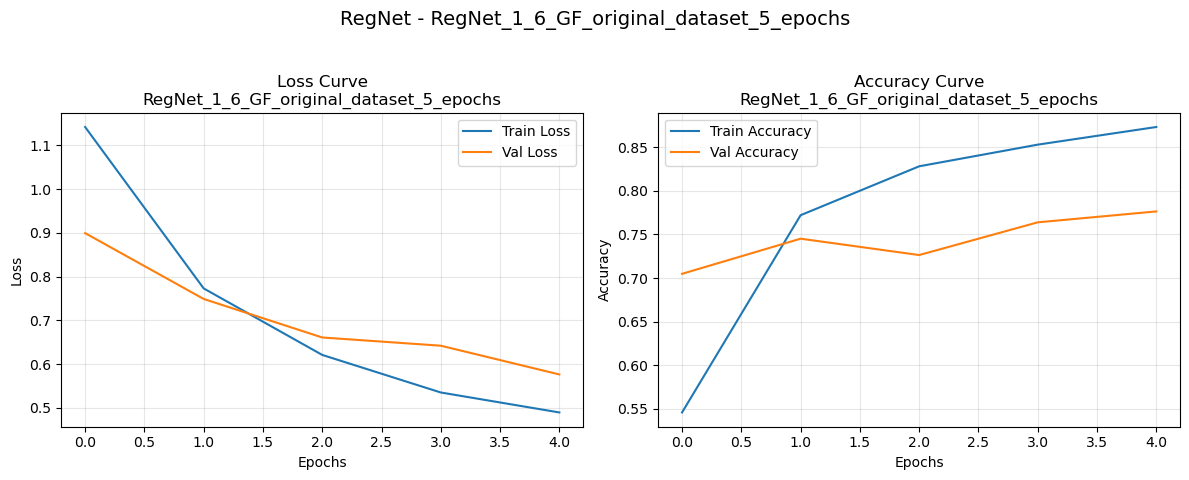

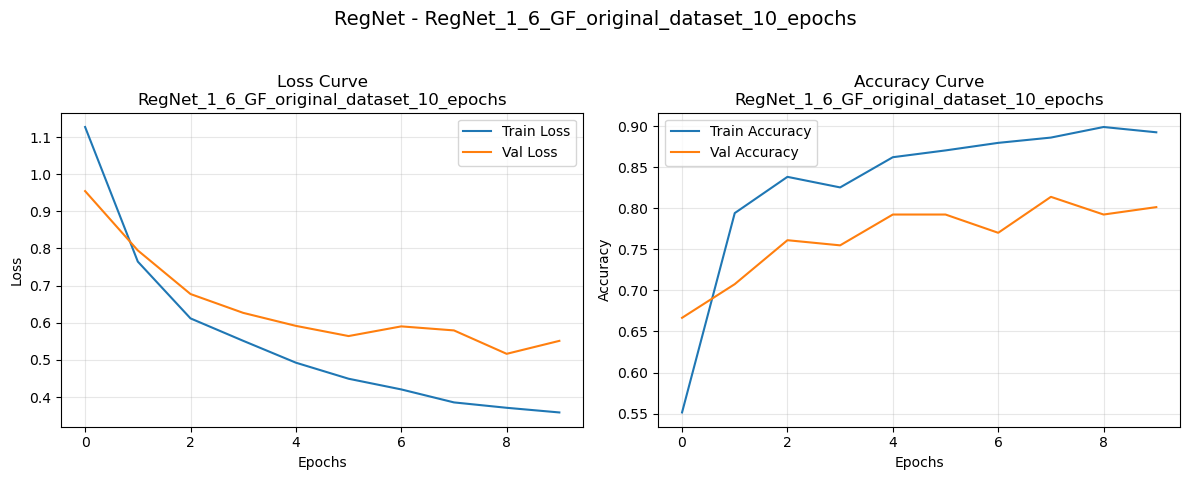

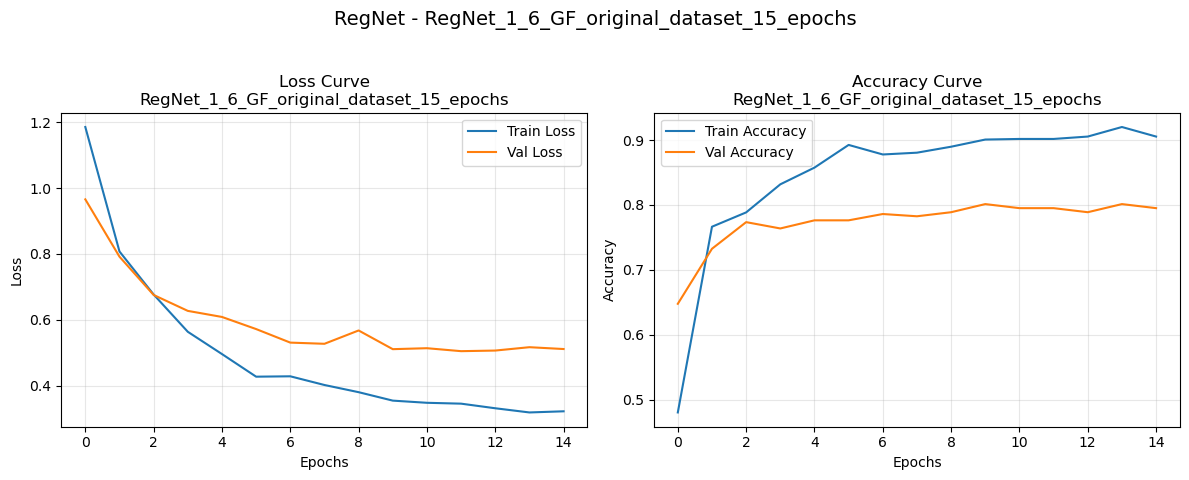

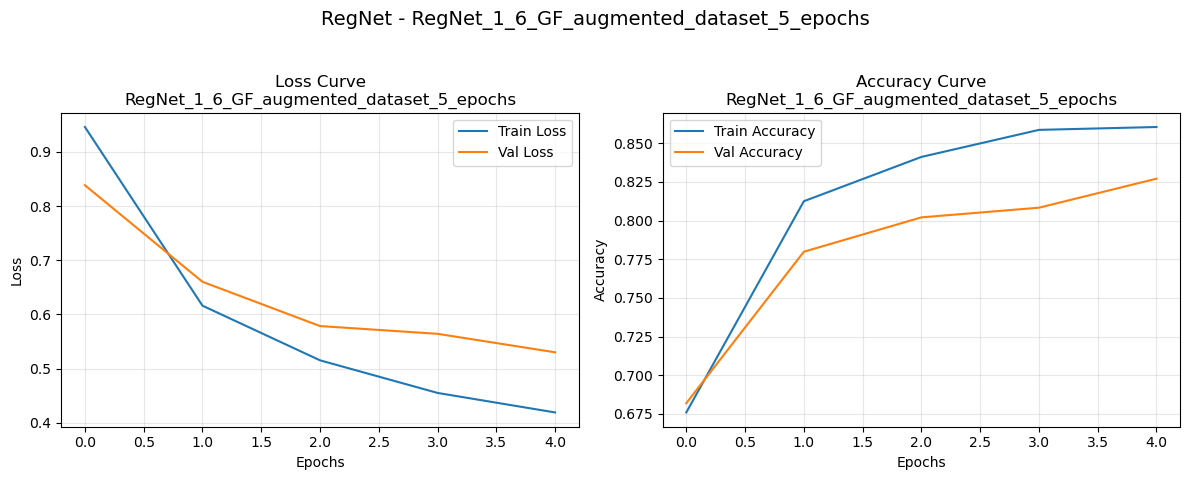

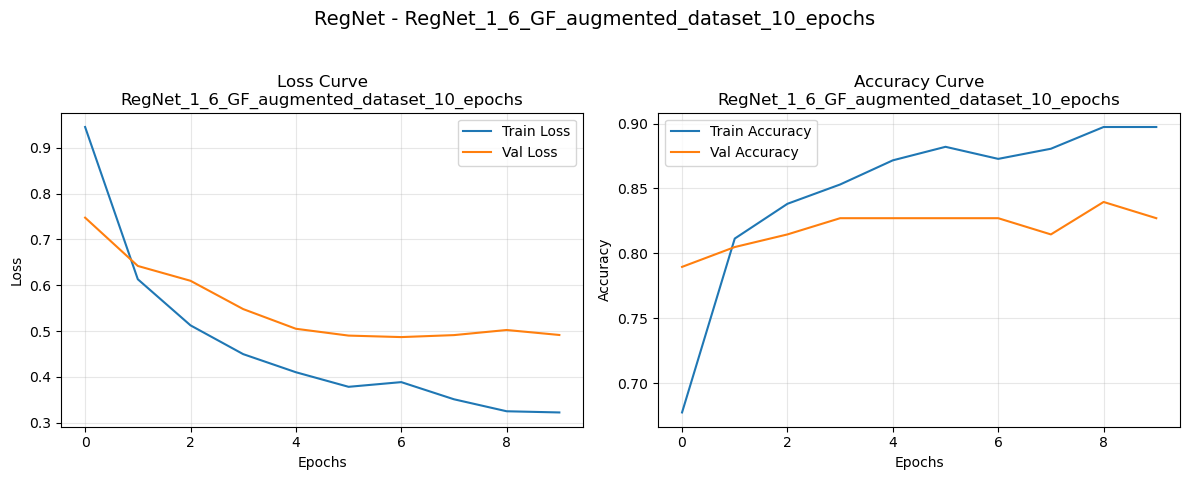

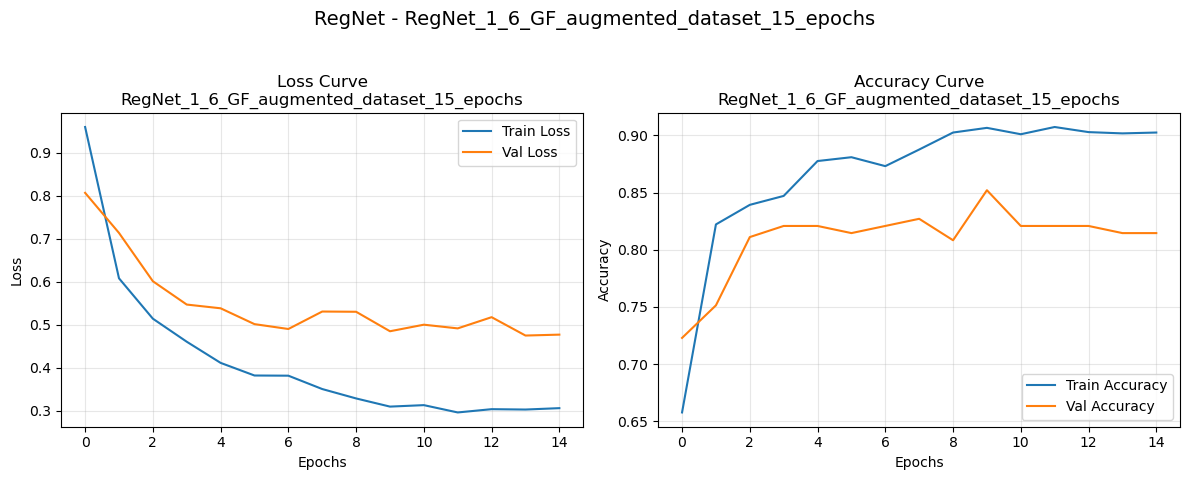

In [3]:
plot_loss_curves_separate_figures(
    pickle_path="Publication_Exp_Logs/Regnet_y_one_point_six.pkl",
    save_plots=False# Set to True if you want to save figures
)

* 15 epochs on the Augmented Data is the better model for RegNet_Y_1.2_GF 
* Train Accuracy: 90.25% and Validation Accuracy: 81.46%

### 4.2 ConvNeXT Small

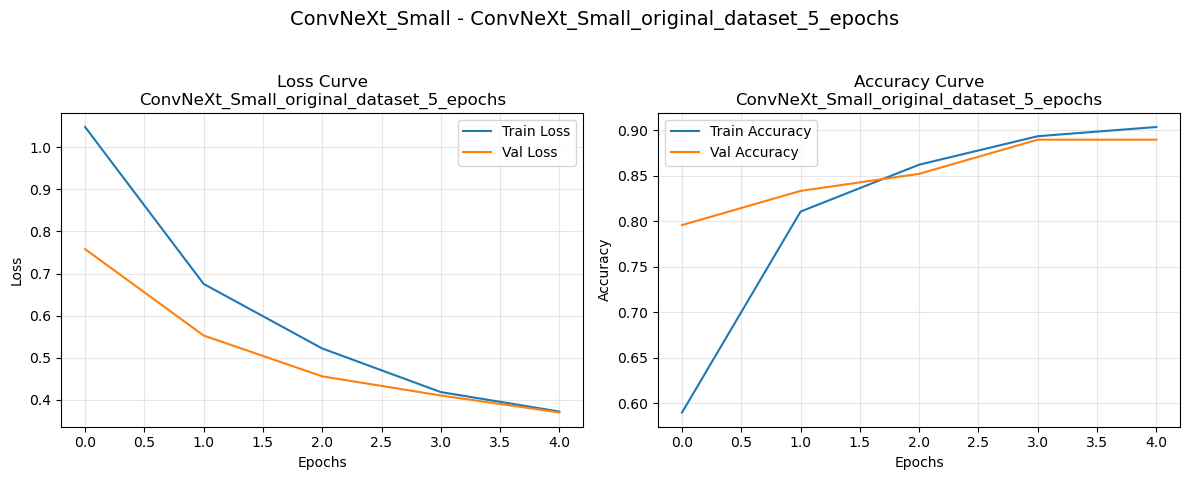

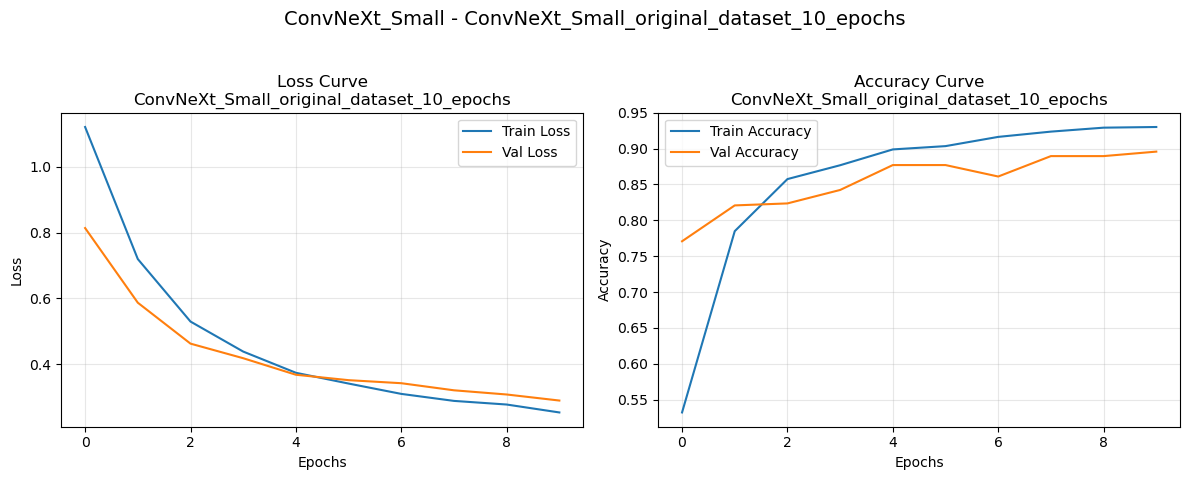

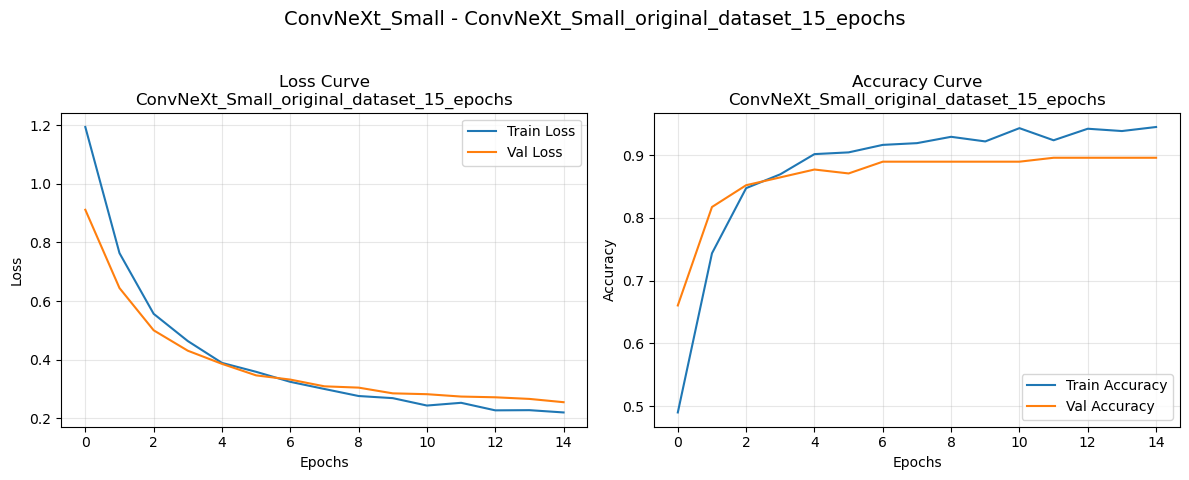

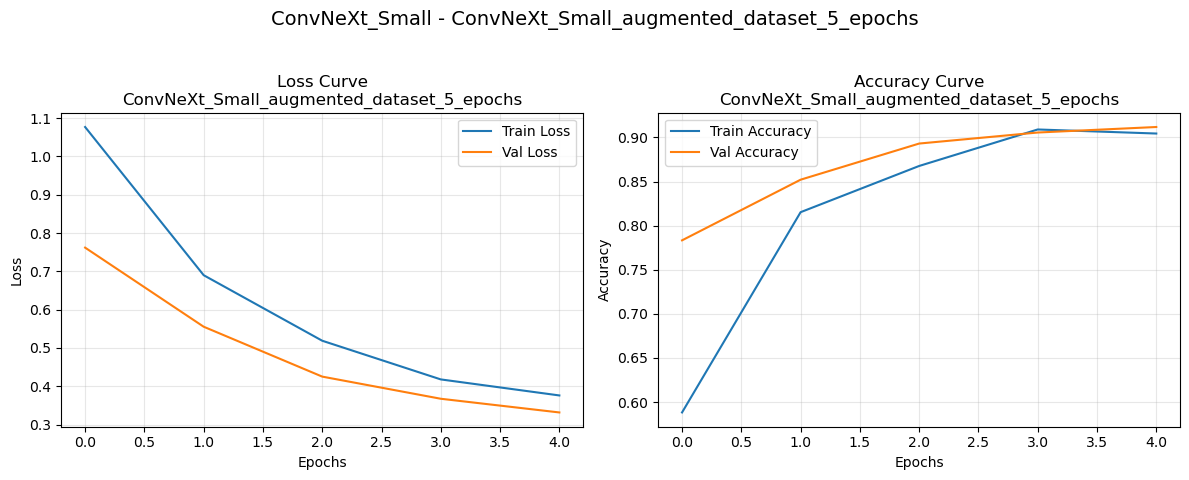

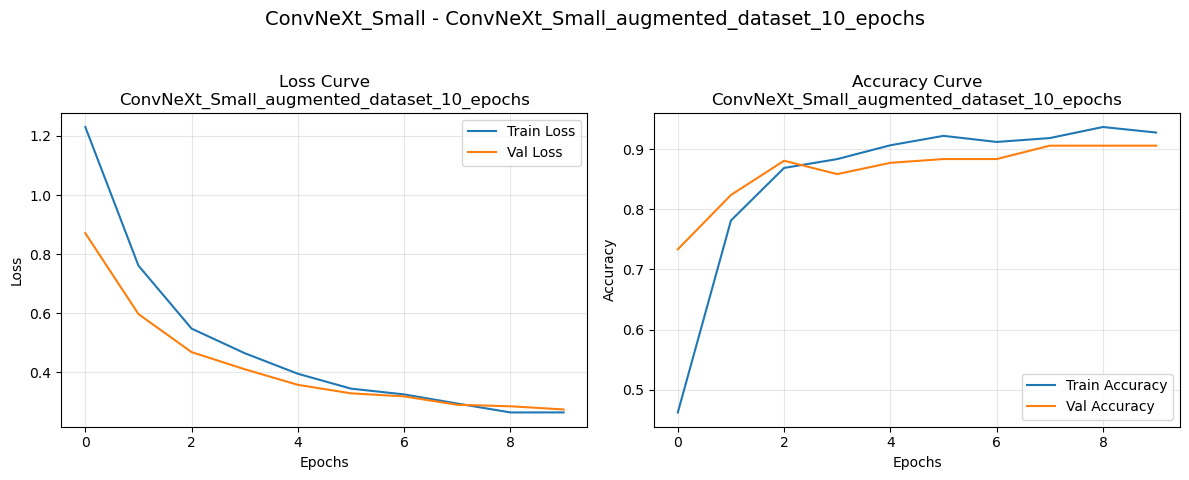

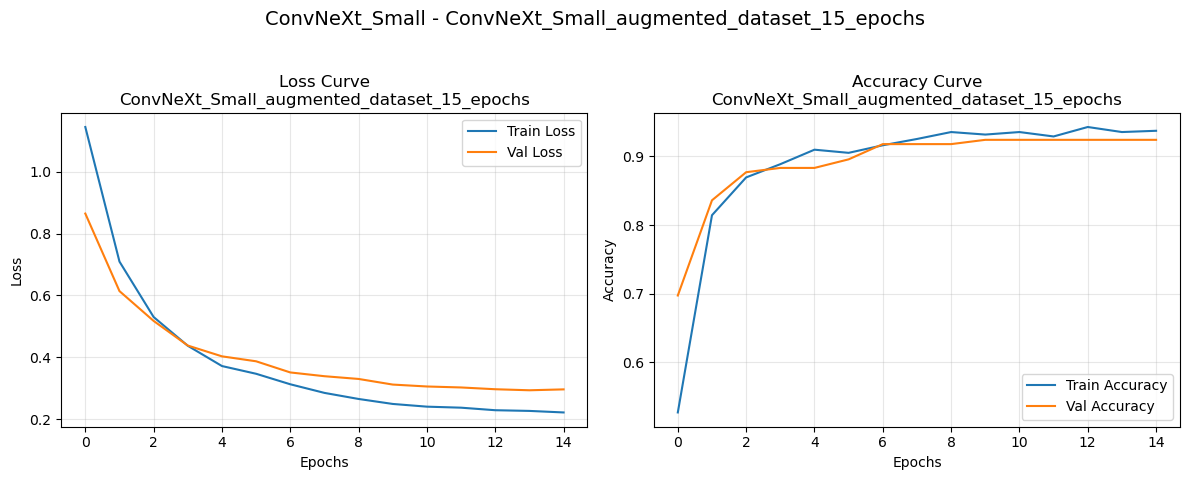

In [4]:
plot_loss_curves_separate_figures(pickle_path='Publication_Exp_Logs/ConvNeXT_Small.pkl',
                                 model_name='ConvNeXt_Small',
                                 save_plots=False)

* 15 epochs on the Augmented Data is the best model for ConvNeXt_Small
* Train Accuracy: 93.75% and Validation Accuracy: 92.43%